In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
#Lectura de datos 
data = pd.read_csv('DEPURACION_FINAL.csv', sep=',')
data

,AÑO,MES,DIA,FECHA,HORA,KW-H
0,2015,1,jueves,1,0,3200
1,2015,1,jueves,1,1,3200
2,2015,1,jueves,1,2,2400
3,2015,1,jueves,1,3,2400
4,2015,1,jueves,1,4,2400
...,...,...,...,...,...,...
43819,2019,12,martes,31,19,3400
43820,2019,12,martes,31,20,3600
43821,2019,12,martes,31,21,3800
43822,2019,12,martes,31,22,4000


In [4]:
#Verificacion de nans 
data.isnull().values.any()
data.isnull().sum().sum()

data.isnull().sum()

AÑO      0
MES      0
DIA      0
FECHA    0
HORA     0
KW-H     0
dtype: int64

In [5]:
#Variable categrica DIA a numérica
#TODO Borrar al final de cuentas no se usa este dato 
data['DIA'] = data['DIA'].map({'lunes': 1 ,
                                           'martes': 2,
                                           'miercoles': 3,
                                           'miércoles': 3,
                                           'jueves': 4 , 
                                           'viernes': 5, 
                                           'sábado': 6,
                                           'sabado': 6,  #inconsistencia en la data por las tildes
                                           'domingo': 7})




In [6]:
data.tail(50)

,AÑO,MES,DIA,FECHA,HORA,KW-H
43774,2019,12,7,29,22,3200
43775,2019,12,7,29,23,2800
43776,2019,12,1,30,0,2400
43777,2019,12,1,30,1,2400
43778,2019,12,1,30,2,2000
43779,2019,12,1,30,3,2000
43780,2019,12,1,30,4,2000
43781,2019,12,1,30,5,2000
43782,2019,12,1,30,6,2000
43783,2019,12,1,30,7,1800


In [7]:
#Llevamos la hora y la fecha para los indices porque lo que nos interesa es KW-H
from datetime import datetime 
data_final = pd.DataFrame()
fechas_dt = []
kwh_dt = []
for registro in data.values:
    fecha = "{}-{}-{} {}".format(registro[0], registro[1], registro[3], registro[4])
    fecha_dt = datetime.strptime(fecha, '%Y-%m-%d %H')
    fechas_dt.append(fecha_dt)
    kwh_dt.append(registro[5])
#Creamos un nuevo dataframe con el formato de fecha correcto y el valor de KW-H
data_final['FECHA'] = fechas_dt
data_final['KW-H'] = kwh_dt
data_final

,FECHA,KW-H
0,2015-01-01 00:00:00,3200
1,2015-01-01 01:00:00,3200
2,2015-01-01 02:00:00,2400
3,2015-01-01 03:00:00,2400
4,2015-01-01 04:00:00,2400
...,...,...
43819,2019-12-31 19:00:00,3400
43820,2019-12-31 20:00:00,3600
43821,2019-12-31 21:00:00,3800
43822,2019-12-31 22:00:00,4000


In [8]:
#Llevamos la FECHA al indice de nuestro df, ahora solo tenemos una columna de datos
data_final.set_index('FECHA', drop=True, inplace = True)
data_final

,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2019-12-31 19:00:00,3400
2019-12-31 20:00:00,3600
2019-12-31 21:00:00,3800


In [9]:
#Dividir los datos de entrenamiento y de test
# No se puede utilizar train test split, debemos dividir en el ultimo segmento 
#Tomamos los datos para validacion el 20%, pero del final de los datos (casi lo del año 2019)
size = int(0.2*data_final.shape[0])
data_test = data_final[-size:]
data_train = data_final[:-size]
data_train


,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2018-12-31 15:00:00,2500
2018-12-31 16:00:00,2500
2018-12-31 17:00:00,2400


In [10]:
#Transformacion de datos a numerica

data_train['KW-H'] = [valor.replace(",", ".") for valor in data_train['KW-H'] ]
data_train['KW-H'] = [float(valor) for valor in data_train['KW-H'] ]

data_test['KW-H'] = [valor.replace(",", ".") for valor in data_test['KW-H'] ]
data_test['KW-H'] = [float(valor) for valor in data_test['KW-H'] ]

data_train

/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher

,KW-H
FECHA,
2015-01-01 00:00:00,3200.0
2015-01-01 01:00:00,3200.0
2015-01-01 02:00:00,2400.0
2015-01-01 03:00:00,2400.0
2015-01-01 04:00:00,2400.0
...,...
2018-12-31 15:00:00,2500.0
2018-12-31 16:00:00,2500.0
2018-12-31 17:00:00,2400.0


In [11]:
#Normalizacion de los datos
#Para LSTM es obligatoria la normalización, en este caso lo hacemos de 0 a 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_train_scaled = sc.fit_transform(data_train)
print(data_train_scaled.shape)
data_train_scaled
 


(35060, 1)


array([[0.66666667],
       [0.66666667],
       [0.5       ],
       ...,
       [0.5       ],
       [0.47916667],
       [0.47916667]])

In [12]:
#Tenemos que entrenar la red por bloques de datos 
#Time_step es el tamaño del bloque 
#Cada n datos genera una salida 
#Tomamos bloques de 60 datos consecutivos 
time_step = 60 
X_train = [] #Lista de conjuntos de 60 datos 
Y_train = []
m = len(data_train_scaled)
for i in range(time_step, m):
    X_train.append(data_train_scaled[i-time_step:i, 0]) #Guardamos 60 valores
    Y_train.append(data_train_scaled[i, 0]) #Buscamos predecir el dato time_step + 1, no la var KW
X_train, Y_train = np.array(X_train), np.array(Y_train) #Usamos np por reshape y optimizacion



In [13]:
X_train.shape, Y_train.shape

((35000, 60), (35000,))

In [14]:
#Obligatorio el reshape de los datos, es obligatorio por Keras, nos pide ingresar un array de 3 dim
#Llevamos de dos a 3 dimensiones nuestro arreglo 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Agregamos una nueva dimension
X_train.shape, Y_train.shape

((35000, 60, 1), (35000,))

In [15]:
#MODELO
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


In [125]:
#Este intento es con la fecha con index y todo refactorizado

dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 16


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
#TODO posible dropout
#Capa 2
model.add(LSTM(units=8))

#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
model.fit(X_train, Y_train, epochs = 20, batch_size = 128)

Epoch 1/20
35000/35000 [==============================] - 83s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0809
Epoch 2/20
35000/35000 [==============================] - 105s 3ms/step - loss: 0.0061 - mean_absolute_error: 0.0503
Epoch 3/20
35000/35000 [==============================] - 106s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0391
Epoch 4/20
35000/35000 [==============================] - 104s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0319
Epoch 5/20
35000/35000 [==============================] - 114s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0282
Epoch 6/20
35000/35000 [==============================] - 103s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0263
Epoch 7/20
35000/35000 [==============================] - 107s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0253
Epoch 8/20
35000/35000 [==============================] - 107s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0248
Epoch 9/20
35000/35000 [==============================] - 106s 3m

In [17]:
#Este intento es con la fecha con index y todo refactorizado, 
#AHORA CON DRPOUT DE 40% y luego del 20% de las neuronas, para evitar overfitting

#ADAM
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 16


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
model.add(Dropout(0.4))
#Capa 2
model.add(LSTM(units=8))
model.add(Dropout(0.2))

#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='adam', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
model.fit(X_train, Y_train, epochs = 10, batch_size = 64)

2022-01-17 13:00:42.700095: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 13:00:42.701082: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
35000/35000 [==============================] - 114s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.1192
Epoch 2/10
35000/35000 [==============================] - 178s 5ms/step - loss: 0.0147 - mean_absolute_error: 0.0890
Epoch 3/10
35000/35000 [==============================] - 182s 5ms/step - loss: 0.0109 - mean_absolute_error: 0.0757
Epoch 4/10
35000/35000 [==============================] - 171s 5ms/step - loss: 0.0086 - mean_absolute_error: 0.0659
Epoch 5/10
35000/35000 [==============================] - 174s 5ms/step - loss: 0.0073 - mean_absolute_error: 0.0598
Epoch 6/10
35000/35000 [==============================] - 185s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0557
Epoch 7/10
35000/35000 [==============================] - 150s 4ms/step - loss: 0.0061 - mean_absolute_error: 0.0530
Epoch 8/10
35000/35000 [==============================] - 146s 4ms/step - loss: 0.0057 - mean_absolute_error: 0.0512
Epoch 9/10
35000/35000 [==============================] - 170s 5

In [18]:
#TEST
#Para el test es necesario agrupar los datos de test, normalizar y hacer el reashape como se hizo 
#para el conjunto de entrenamiento
x_test  = data_test.values
x_test = sc.transform(x_test) #Normalizacion
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0]) #Grupos de datos 
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  #Reshape
X_test.shape
prediccion = model.predict(X_test) #Predicción
prediccion = sc.inverse_transform(prediccion) # Regresamos el escalamiento de datos

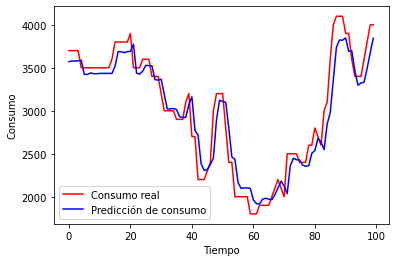

In [19]:
#Grafica de valores (solo tomamos los últimos 100 para efectos de visualización) 
plt.plot(data_test.values[-100:], color='red', label='Consumo real')
plt.plot(prediccion[-100:], color='blue', label='Predicción de consumo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [20]:
#Este intento es con la fecha con index y todo refactorizado
#AHORA CON DRPOUT DE 40%

#SGD
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 16


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
model.add(Dropout(0.4))
#Capa 2
model.add(LSTM(units=8))
model.add(Dropout(0.2))

#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='adadelta', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
model.fit(X_train, Y_train, epochs = 10, batch_size = 64)

Epoch 1/10
35000/35000 [==============================] - 133s 4ms/step - loss: 0.0438 - mean_absolute_error: 0.1396
Epoch 2/10
35000/35000 [==============================] - 151s 4ms/step - loss: 0.0118 - mean_absolute_error: 0.0789
Epoch 3/10
35000/35000 [==============================] - 156s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0652
Epoch 4/10
35000/35000 [==============================] - 131s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0596
Epoch 5/10
35000/35000 [==============================] - 74s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0566
Epoch 6/10
35000/35000 [==============================] - 152s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0542
Epoch 7/10
35000/35000 [==============================] - 179s 5ms/step - loss: 0.0060 - mean_absolute_error: 0.0532
Epoch 8/10
35000/35000 [==============================] - 172s 5ms/step - loss: 0.0058 - mean_absolute_error: 0.0521
Epoch 9/10
35000/35000 [==============================] - 197s 6m

In [21]:
x_test  = data_test.values
x_test = sc.transform(x_test)
# # x_test
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

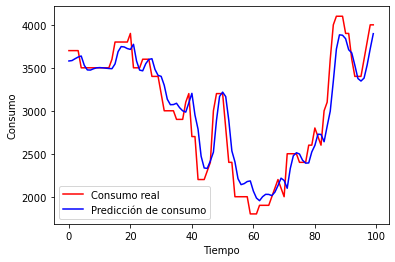

In [22]:
#Grafica de valores
# Y_test #Aun no defnido 
plt.plot(data_test.values[-100:], color='red', label='Consumo real')
plt.plot(prediccion[-100:], color='blue', label='Predicción de consumo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [23]:
#rmsprop LOS MEJORES RESULTADOS
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 16


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
model.add(Dropout(0.4))
#Capa 2
model.add(LSTM(units=8))
model.add(Dropout(0.2))

#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
model.fit(X_train, Y_train, epochs = 10, batch_size = 64)

Epoch 1/10
35000/35000 [==============================] - 165s 5ms/step - loss: 0.0328 - mean_absolute_error: 0.1228
Epoch 2/10
35000/35000 [==============================] - 156s 4ms/step - loss: 0.0100 - mean_absolute_error: 0.0720
Epoch 3/10
35000/35000 [==============================] - 157s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0575
Epoch 4/10
35000/35000 [==============================] - 154s 4ms/step - loss: 0.0058 - mean_absolute_error: 0.0520
Epoch 5/10
35000/35000 [==============================] - 144s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0496
Epoch 6/10
35000/35000 [==============================] - 137s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0489
Epoch 7/10
35000/35000 [==============================] - 140s 4ms/step - loss: 0.0050 - mean_absolute_error: 0.0479
Epoch 8/10
35000/35000 [==============================] - 191s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0477
Epoch 9/10
35000/35000 [==============================] - 184s 5

In [24]:
x_test  = data_test.values
x_test = sc.transform(x_test)
# # x_test
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

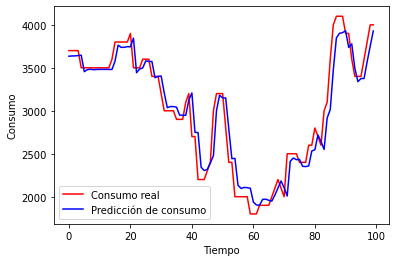

In [25]:
#Grafica de valores
# Y_test #Aun no defnido 
plt.plot(data_test.values[-100:], color='red', label='Consumo real')
plt.plot(prediccion[-100:], color='blue', label='Predicción de consumo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
#Intento con 20 epocas y batch de 128, sin dropout
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 48
dim_entrada

In [15]:
#Nuevo tamano, solo entrenar con el KW-H

model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
#TODO posible dropout
#Capa 2
model.add(LSTM(units=24))

#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
model.fit(X_train, Y_train, epochs = 20, batch_size = 128)

2022-01-17 08:00:58.962327: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 08:00:58.964218: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
35004/35004 [==============================] - 88s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0656
Epoch 2/20
35004/35004 [==============================] - 113s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0391
Epoch 3/20
35004/35004 [==============================] - 125s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0321
Epoch 4/20
35004/35004 [==============================] - 134s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0298
Epoch 5/20
35004/35004 [==============================] - 129s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0281
Epoch 6/20
35004/35004 [==============================] - 123s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0278
Epoch 7/20
35004/35004 [==============================] - 132s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0270
Epoch 8/20
35004/35004 [==============================] - 132s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0265
Epoch 9/20
35004/35004 [==============================] - 136s 4m

In [ ]:
#TODO Graficas y test...